# Change and Tracking

Kevin J. Walchko
created 30 September 2017

---

We are going to talk about change detection. Basically, we want to know when has a scene changed because we are trying to count the number of people leaving a building, how many cars are on a road, or did someone just plant a bomb by leaving a bag in an airport? There are many ways to do this and we will look at a couple.

## Objectives

- understand how to detect change between 2 images
- understand how to use the OpenCV blob interface

## References

- [OpenCV Tutorials](http://docs.opencv.org/3.1.0/db/d5c/tutorial_py_bg_subtraction.html)
- [OpenCV source code on github](https://github.com/opencv/opencv)
- [OpenCV 3.3 Docs](http://docs.opencv.org/3.3.0/)
- [OpenCV 3.3 Python Tutorials](http://docs.opencv.org/3.3.0/d6/d00/tutorial_py_root.html)

## Setup

In [27]:
from __future__ import print_function
# these imports let you use opencv
import cv2          # opencv itself
# import common       # some useful opencv functions
# import video        # some video stuff
import numpy as np  # matrix manipulations

%matplotlib inline 
from matplotlib import pyplot as plt           # this lets you draw inline pictures in the notebooks
import pylab                                   # this allows you to control figure size 
pylab.rcParams['figure.figsize'] = (10.0, 18.0) # this controls figure size in the notebook

- [track](https://www.learnopencv.com/object-tracking-using-opencv-cpp-python/)

- Dense Optical flow: These algorithms help estimate the motion vector of every pixel in a video frame.
- Sparse optical flow: These algorithms, like the Kanade-Lucas-Tomashi (KLT) feature tracker, track the location of a few feature points in an image.
- Kalman Filtering: A very popular signal processing algorithm used to predict the location of a moving object based on prior motion information. One of the early applications of this algorithm was missile guidance! Also as mentioned here, “the on-board computer that guided the descent of the Apollo 11 lunar module to the moon had a Kalman filter”.
- Meanshift and Camshift: These are algorithms for locating the maxima of a density function. They are also used for tracking.
- Single object trackers: In this class of trackers, the first frame is marked using a rectangle to indicate the location of the object we want to track. The object is then tracked in subsequent frames using the tracking algorithm. In most real life applications, these trackers are used in conjunction with an object detector.
- Multiple object track finding algorithms: In cases when we have a fast object detector, it makes sense to detect multiple objects in each frame and then run a track finding algorithm that identifies which rectangle in one frame corresponds to a rectangle in the next frame.

# Background Subtraction

Background subtraction is a major preprocessing steps in many vision based applications. For example, consider the cases like visitor counter where a static camera takes the number of visitors entering or leaving the room, or a traffic camera extracting information about the vehicles etc. In all these cases, first you need to extract the person or vehicles alone. Technically, you need to extract the moving foreground from static background.

If you have an image of background alone, like image of the room without visitors, image of the road without vehicles etc, it is an easy job. Just subtract the new image from the background. You get the foreground objects alone. But in most of the cases, you may not have such an image, so we need to extract the background from whatever images we have. It become more complicated when there is shadow of the vehicles. Since shadow is also moving, simple subtraction will mark that also as foreground. It complicates things.

Several algorithms were introduced for this purpose. OpenCV has implemented several such algorithms which is very easy to use.

## Simple Subtraction

First let's do the simple method of change detection. Given an image of the background, do a simple subtraction pixel by pixel and determine if the scene has changed.

![](subtract.png)

Now this method is very simple and straight forward. However, it has several issues:

- I need to have a background picture before I start to determine if the scene changed ... you don't always have that
- You need the same lighting in the background picture and the picture that might contain change, otherwise, a lot of pixels will register change.
    - If you are doing this outdoors, then you will have issues with the sun moving and shadows changing
    - You will also, obviously, have issues with day/night or full moon/new moon lighting conditions
- Although most camera are made fairly well now a days, you will still have slight variations in the same pixel capturing the same scene from frame to frame. This is a function of:
    - how photons hit the pixel during an integration time
    - camera focal plane noise
    - encoding or compression artifact the camera will introduce before your program gets the image

## BackgroundSubtractorMOG

**This one seems to be missing on my version of OpenCV 3.3 on macOS**

It is a Gaussian Mixture-based Background/Foreground Segmentation Algorithm. It was introduced in the paper "An improved adaptive background mixture model for real-time tracking with shadow detection" by P. KadewTraKuPong and R. Bowden in 2001. It uses a method to model each background pixel by a mixture of K Gaussian distributions (K = 3 to 5). The weights of the mixture represent the time proportions that those colours stay in the scene. The probable background colours are the ones which stay longer and more static.

While coding, we need to create a background object using the function, cv2.createBackgroundSubtractorMOG(). It has some optional parameters like length of history, number of gaussian mixtures, threshold etc. It is all set to some default values. Then inside the video loop, use backgroundsubtractor.apply() method to get the foreground mask.

## BackgroundSubtractorMOG2

It is also a Gaussian Mixture-based Background/Foreground Segmentation Algorithm. It is based on two papers by Z.Zivkovic, "Improved adaptive Gausian mixture model for background subtraction" in 2004 and "Efficient Adaptive Density Estimation per Image Pixel for the Task of Background Subtraction" in 2006. One important feature of this algorithm is that it selects the appropriate number of gaussian distribution for each pixel. (Remember, in last case, we took a K gaussian distributions throughout the algorithm). It provides better adaptibility to varying scenes due illumination changes etc.

As in previous case, we have to create a background subtractor object. Here, you have an option of selecting whether shadow to be detected or not. If detectShadows = True (which is so by default), it detects and marks shadows, but decreases the speed. Shadows will be marked in gray color.


- BackgroundSubtractorMOG2(BackgroundSubtractor) = creates a MOG2 object
- MOG2.apply(image, learningRate) = produces a grayscale image [0, 255] with some noise/stray pixels showing change
    - **learningRate:** The value between 0 and 1 that indicates how fast the background model is
- MOG2.setDetectShadows(**True or False**)

```python
def MOG2(cap):
    # this function takes in cv2.VideoCapture() object which is either a camera
    # or a video (i.e., mp4) and runs through the images performing background
    # subtraction
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    print('kernel', kernel)
    fgbg = cv2.createBackgroundSubtractorMOG2()
    # fgbg.setDetectShadows(False)

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # find the change
        fgmask = fgbg.apply(frame)
        # clean up the image
        fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)

        cv2.imshow('frame',fgmask)
        k = cv2.waitKey(10)
        if k == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
```

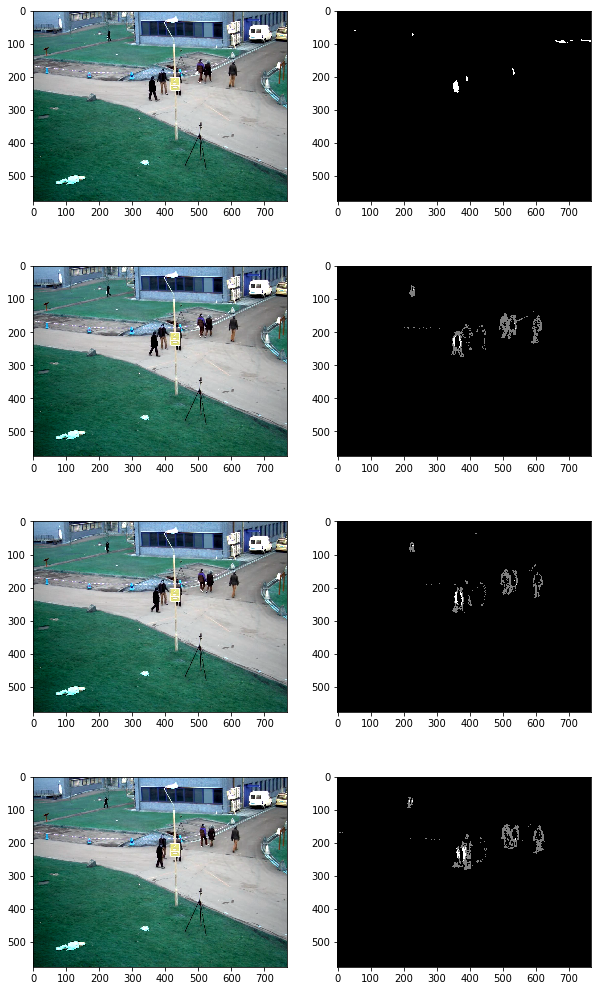

In [28]:
def MOG2(frames):
    # this function takes in cv2.VideoCapture() object which is either a camera
    # or a video (i.e., mp4) and runs through the images performing background
    # subtraction
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
#     print('kernel', kernel)
    fgbg = cv2.createBackgroundSubtractorMOG2()
    # fgbg.setDetectShadows(False)
    
    ret = []

    for frame in frames:
        # find the change
        fgmask = fgbg.apply(frame)
        # clean up the image
        fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)
        ret.append(fgmask)
    return ret

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
fgbg = cv2.createBackgroundSubtractorMOG2()

f0 = cv2.imread('frame101.png')
f1 = cv2.imread('frame102.png')
f2 = cv2.imread('frame103.png')
f3 = cv2.imread('frame104.png')
inputs = [f0, f1,f2,f3]

masks = MOG2(inputs)

for ii, i, m in zip([1,3, 5, 7], inputs, masks):
    plt.subplot(4,2,ii)
    plt.imshow(i)
    plt.subplot(4,2,ii+1)
    plt.imshow(m, cmap='gray')

In the first image, since it is new and hasn't learned much from the first image, the change detection isn't that great. However, there is already a big difference in the second and remaining images. We can see people moving around, separated from the back ground much better.

Take a look at the `bg.py` file with this lesson. You can select (via commenting or uncommenting code in it) between the movie or your camera in the laptop. Also, you can play with the learning rate and see how that changes the performance.


-----------

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.